# GoEmotions Exploratory Data Analysis

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from wordcloud import WordCloud, STOPWORDS 


## About the Dataset

Understanding emotion has been a long term goal in NLP. There are variety of applications for machines to understand emotion, from detecting harmful online behavior all the way to empathetic chatbots. 

In the past, existing datasets that contain labled data useful for emotion classification have mostly been both small and/or limited in emotion taxonomy (usually with just positive or negative emotion). Demszky, Movshovitz-Attias, Ko, Cowen, Nemade, Ravi are researchers at Stanford, Google, and Amazon and have created a human labeled dataset of 58k Reddit comments, labeled with a comprehensive emotion taxonomy of 28 emotion categories. Building a model that can accurately classify emotions into such a larger emotion taxonomy will be huge step forward for Natural language understanding.

### Emotion Taxonomy
One of the main aspects that distinguishes this dataset is the emotion taxonomy. Ekman (1992a) and other researchers in the past have proposed 6 basic emotion categories (joy, anger, fear, sadness, disgust, and surprise), but this dataset expands on these emotion categories into a more fine-grained 27 + Neutral emotional categories. These categories were selected base of the study of distribution of emotion responses to a diverse array of stimuli via computational techniques. They attempt to provide the greatest coverage of emotions expressed in the dataset, coverage in terms of general emotional expression, and limited overlap between emotional categories.

## Selecting and Curating Reddit comments
Comments are from 2005 to January 2019, selecting subreddits with at least 10k comments and remove deleted and non-English comments. There is a skew toward offensive language, so the authors have taken some measures to curate the data:
- reduce profanity where 10%+ of comments include offensive/adult and vulgar tokens
- manually review comments to remove offensive material
- length filtering, comments that are 3-30 tokens long
- sentiment and emotion balancing
- masking, replacing proper names with [NAME]



## Loading Data


In [801]:
dev = pd.read_csv("data/dev.tsv", sep="\t", header = None, names = ["comment", "emotion_id", "id"])
test = pd.read_csv("data/test.tsv", sep="\t", header = None, names = ["comment", "emotion_id", "id"])
train = pd.read_csv("data/train.tsv", sep="\t", header = None, names = ["comment", "emotion_id", "id"])

print("Development Data Shape:", dev.shape)
print("Test Data Shape:", test.shape)
print("Train Data Shape:", train.shape)
dev.head(20)

dev.shape[0] + test.shape[0] + train.shape[0]

Development Data Shape: (5426, 3)
Test Data Shape: (5427, 3)
Train Data Shape: (43410, 3)


54263

In [308]:
emotions = pd.read_csv("data/emotions.txt", header=None, names=["emotions"])
emotions

,emotions
0,admiration
1,amusement
2,anger
3,annoyance
4,approval
5,caring
6,confusion
7,curiosity
8,desire
9,disappointment


In [309]:
# turning string emotions into list of lists
def emotion_str_to_list(emotion_id_list):
    """Takes in pd_series of emotions in string format and turns to list of lists"""
    emotion_id_list = list(emotion_id_list)
    for i,e in enumerate(emotion_id_list):
        try: 
            emotion_id_list[i] = list[int(e)]
        except:
            emotions = e.split(',')
            emotion_id_list[i] = [int(emo) for emo in emotions] 
    return emotion_id_list


# duplicating comments with multiple emotion_ids
def duplicate_comments(dataset):
    """Takes in dataframe and returns new dataframe with duplicated comments where comment has multiple emotion_ids
    so that there is 1:1 comment to rating"""
    
    table ={"comment":[], "emotion_id":[], "id":[]}
    for comment in dataset.itertuples():
        if len(comment.emotion_id) > 1:
            for i in comment.emotion_id:
                table["comment"].append(comment.comment)
                table["emotion_id"].append(i)
                table["id"].append(comment.id)
        else:
            table["comment"].append(comment.comment)
            table["emotion_id"].append(int(comment.emotion_id[0]))
            table["id"].append(comment.id)
    
    return pd.DataFrame(data=table)

In [310]:
#apply emotion_str_to_list and duplicate comments to data
dev_new = dev.drop(columns="emotion_id")
dev_new["emotion_id"] = emotion_str_to_list(dev["emotion_id"])
dev = duplicate_comments(dev_new)

test_new = test.drop(columns="emotion_id")
test_new["emotion_id"] = emotion_str_to_list(test["emotion_id"])
test = duplicate_comments(test_new)

train_new = train.drop(columns="emotion_id")
train_new["emotion_id"] = emotion_str_to_list(train["emotion_id"])
train = duplicate_comments(train_new)

In [311]:
dev_data=dev['comment']
dev_label = dev['emotion_id']
print("num observations for Dev_data", len(dev_data))

train_data=train['comment']
train_label=train['emotion_id']
print("num observations for Train_data", len(train_data))

test_data=test['comment']
test_label=test['emotion_id']
print("num observations for Test_data", len(test_data))

num observations for Dev_data 6380
num observations for Train_data 51103
num observations for Test_data 6329


## Exploratory Data Analysis

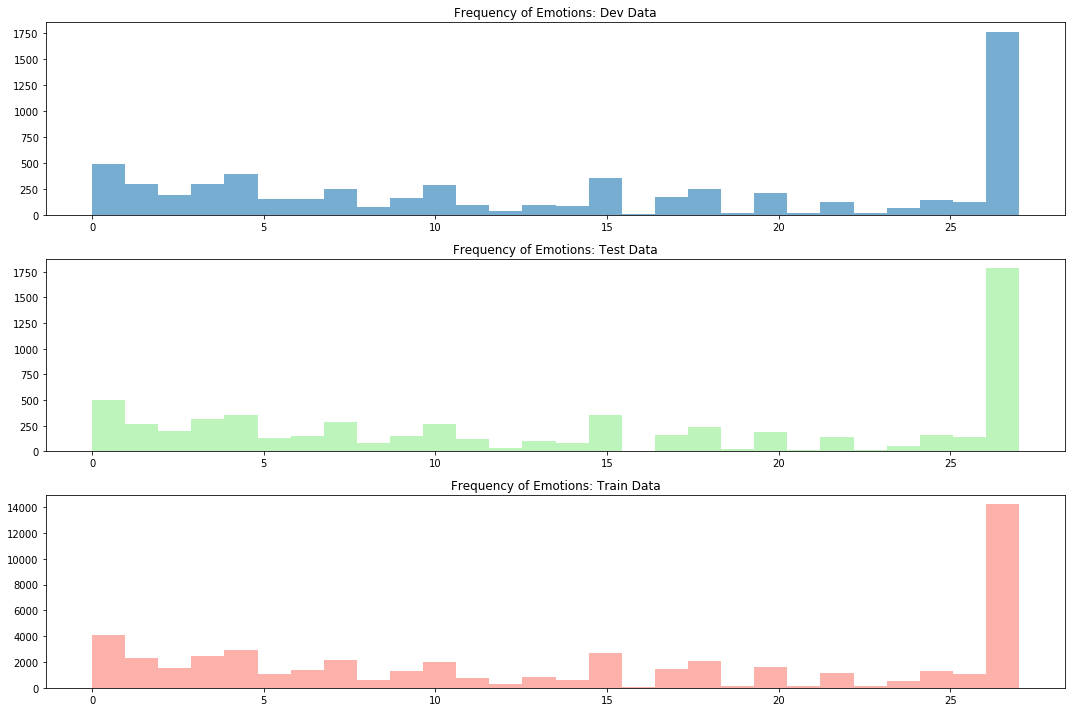

In [312]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].hist(dev_label, bins=28, alpha=0.6)
axs[0].set_title("Frequency of Emotions: Dev Data")
axs[1].hist(test_label, bins=28, color='lightgreen', alpha=0.6)
axs[1].set_title("Frequency of Emotions: Test Data")
axs[2].hist(train_label, bins=28, color='salmon', alpha=0.6)
axs[2].set_title("Frequency of Emotions: Train Data")
fig.tight_layout()

In [313]:
#Examples of emotions 2 14 25

#anger
dev[dev['emotion_id']==2].head(10)

#fear
dev[dev['emotion_id'] == 14].head(10)

#sadness
dev[dev['emotion_id'] == 25].head(10)


,comment,emotion_id,id
3,I've never been this sad in my life!,25,edcu99z
19,Lol dream on buddy. You’ve had enough attentio...,25,ed2znun
22,"1-2-3-4 I declare a thumb war! Dangit [NAME], ...",25,edgygzk
45,*[NAME] making [NAME] even more sad.*,25,ef4jj65
156,I feel bad for my kids who will never get to s...,25,edxub2h
204,I just need [NAME] to retire already so I can ...,25,ef5m49k
268,Being born in north america is a curse my frie...,25,edfb09i
345,I miss those days.,25,ed4wj8r
405,Omg TDG has a new singer? That's so sad. I was...,25,eey07ar
471,I’m offended,25,ef2k0f1


## Baseline Models 

In [314]:
#getting stopwords from nltk package
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words = stop_words + ['name', 'oh', 'really']


In [315]:
#Bag of Words Model with Count Vectorizer

cvector = CountVectorizer(stop_words=stop_words)
c_vtrain = cvector.fit_transform(train_data)
c_vtest = cvector.transform(test_data)
len(cvector.get_feature_names())

26233

In [784]:
#gs = GridSearchCV(estimator = nb, scoring = metrics.make_scorer(metrics.f1_score, average='weighted'), param_grid = alphas, iid = False, cv = 5, return_train_score=True)

nb_c = MultinomialNB(alpha=0.5)
nb_c.fit(c_vtrain, train_label)
test_predict_c = nb_c.predict(c_vtest)
train_predict_c = nb_c.predict(c_vtrain)
print("BOW model with CountVectorizer Accuracy on TEST set:", accuracy_score(test_predict_c, test_label))
print("Bow model with CountVectorizer Accuracy on TRAIN set", accuracy_score(train_predict_c, train_label))
f1_score(test_predict_c, test_label, average='macro')


BOW model with CountVectorizer Accuracy on TEST set: 0.4016432295781324
Bow model with CountVectorizer Accuracy on TRAIN set 0.5803964542199088


/Users/lucaslam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.18296150746307618

/Users/lucaslam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


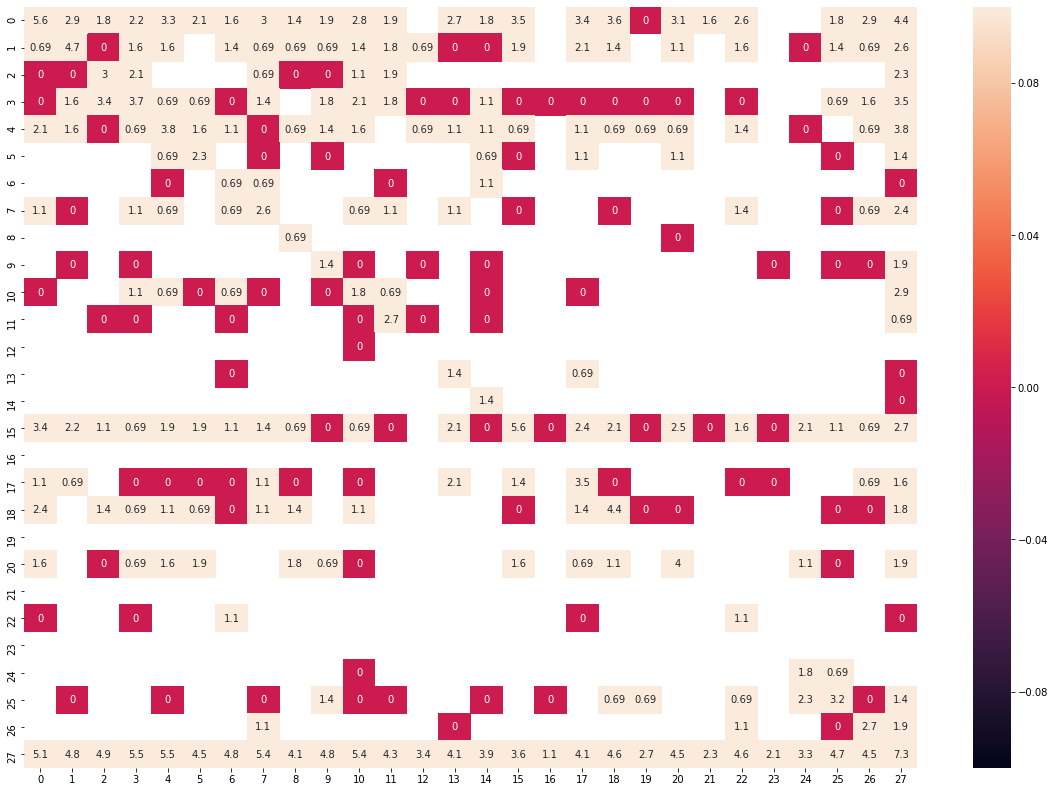

In [512]:
#confusion matrix
import seaborn as sn

confusion_nb_c = np.log(confusion_matrix(test_predict_c, test_label))

df_cm = pd.DataFrame(confusion_nb_c, index = list(range(28)),
                  columns = list(range(28)))
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True)



In [321]:
#Bag of Words Model with TFIDF
tvector = TfidfVectorizer(stop_words=stop_words)
t_vtrain = tvector.fit_transform(train_data)
t_vtest = tvector.transform(test_data)

In [325]:
nb_t = MultinomialNB(alpha=0.2)
nb_t.fit(t_vtrain, train_label)
test_predict_t = nb_t.predict(t_vtest)
print("BOW with TFIDF Vectorizer Accuracy:", accuracy_score(test_predict_t, test_label))


BOW with TFIDF Vectorizer Accuracy: 0.3520303365460578


In [327]:
#Model check... which words have the highest probability to be classified as class 2
def display_words(model, vectorizer, emotion_id, n):
    """function that displays top n words with highest P(word|class)"""
    prob = np.exp(model.feature_log_prob_[emotion_id])
    probs_sorted_index = np.argsort(prob)[::-1] #descending order
    
    vocab = vectorizer.get_feature_names()
    top_n = []
    for i in probs_sorted_index[:n]:
        top_n.append(vocab[i])
    return top_n

emotion_id = input("Enter Emotion ID (0-27):  ")
display_words(nb_c, cvector, int(emotion_id), 10)

Enter Emotion ID (0-27):  25


['sad',
 'sorry',
 'feel',
 'bad',
 'like',
 'sadly',
 'people',
 'one',
 'still',
 'get']

Enter Emotion ID (0-27):  25


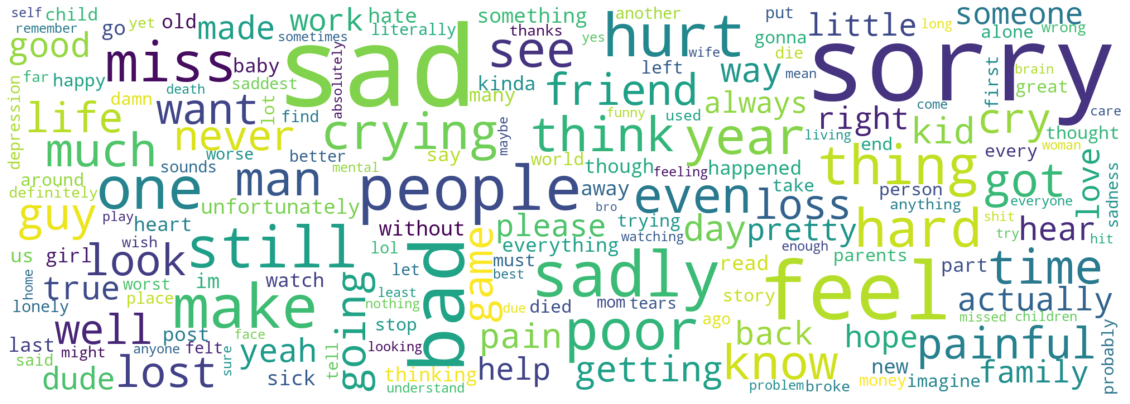

In [328]:
# Generate Word Cloud
def generate_wordcloud(emotion_id, model, vectorizer):
    """Generates word cloud from probabilities from Naive Bayes model"""
    prob = np.exp(model.feature_log_prob_[emotion_id])
    probs_sorted_index = np.argsort(prob)[::-1]
    vocab = vectorizer.get_feature_names()

    #take probability and multiply it by some constant, and throw the words into a pile of text to generate wordcloud
    constant = 10000 #arbitrary
    num_words = 200
    top_words = [vocab[i] for i in probs_sorted_index[:num_words]]
    top_probs = [int(round(constant*prob[i])) for i in probs_sorted_index[:num_words]]
    text = [top_probs[i] * [top_words[i]] for i in range(num_words)]
    text_processed = []
    for word in text:
        for item in word:
            text_processed.append(item)
    text_processed = " ".join(text_processed)
    
    wordcloud = WordCloud(max_font_size=200, collocations=False, background_color="white", width=2000, height=700).generate(text_processed)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
emotion_id = input("Enter Emotion ID (0-27):  ")
generate_wordcloud(int(emotion_id), nb_c, cvector)

Naive Bayes model with CountVectorizer and TFIDF performed quite poorly. Need to use word embeddings.

Suspicions:
- short texts
- doesn't understand context. Not all negative words are negetive not all are positive
- vocabulary is huge... every variation of every word is in the vocabulary.

## Using LSTM with Glove


In [567]:
# tokenizing data, getting rid of punctuation

from nltk.tokenize import TweetTokenizer
import string
from collections import Counter
from pathlib import Path

def loadGloveModel(path, file, num_samples):
    print("Loading Glove Model")
    
    f = open(file,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

def tokenize(comment):
    """Using Tweet Tokenizer """
    try:
        comment_cleaned = "".join([char.lower() for char in comment if char not in string.punctuation]) 
        tokenizer = TweetTokenizer() #getting rid of punctuation
        tokens = tokenizer.tokenize(comment_cleaned) 
        return tokens
    except:
        print(comment)
        return 'NC'
    
def postprocess_tokenize(data):
    """takes in dataframe"""
    
    global vocab, vocab_to_int
    
    data['tokens'] = data['comment'].map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    data_tokens = list(data['tokens'])

    words = []
    for sublist in data_tokens:
        for item in sublist:
            words.append(item)
            
    counts = Counter(words)
    vocab = sorted(counts, key=counts.get, reverse=True)
    vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}
    
    comment_ints = []
    for comment in data_tokens:
        comment_ints.append([vocab_to_int[word] for word in comment])
        
    data['tokens_int'] = comment_ints
    
    return data

#load 6B, 100d text glove embeddings 400,000 vocab
# filepath= Path("/Users/lucaslam/Downloads/glove.6B")
# file = filepath / "glove.6B.100d.txt"
# glove = loadGloveModel(filepath, file, 5)

#load 27B, 100d twitter glove embeddings, 1.2 million vocab
filepath_twt = Path("/Users/lucaslam/Downloads/glove.twitter.27B")
file_twt = filepath_twt / "glove.twitter.27B.200d.txt"
glove_twt = loadGloveModel(filepath_twt, file_twt, 5)


Loading Glove Model
1193514  words loaded!


In [299]:
# Padding Sequence. First find out max and min length and distribution of length of comments to determine 
# length of vectors
max_len = 1
min_len = 1
average_len = []
for comment in list(train_processed["tokens_int"]):
    current = len(comment)
    average_len.append(current)
    if max_len >= current:
        pass
    else:
        max_len = current
    if min_len <= current:
        pass
    else:
        min_len = current
    
print("Average number of words in a comment",sum(average_len)/len(average_len))
print("Max number of words in a comment:", max_len)
print("Min number of words in a comment:", min_len)
print("\n")

percentile_values = [5, 10, 25, 50, 75, 90, 95]
percentile = [np.percentile(average_len, p) for p in percentile_values]
for i,p in enumerate(percentile):
    print(percentile_values[i],"'th Percentile: ", p)
    

Average number of words in a comment 13.347826937753165
Max number of words in a comment: 411
Min number of words in a comment: 0


5 'th Percentile:  3.0
10 'th Percentile:  4.0
25 'th Percentile:  8.0
50 'th Percentile:  13.0
75 'th Percentile:  19.0
90 'th Percentile:  23.0
95 'th Percentile:  25.0


In [528]:
from keras.preprocessing import sequence

#Processing the intpus.
train_processed = postprocess_tokenize(train) 
train_tokens = train_processed['tokens_int'] #tokens to feed into model
train_labels = train_processed['emotion_id'] #labels
train_vocab = vocab #not the best coding practice. Vocab was defined in postprocess_tokenize()
train_vocab_id = vocab_to_int


dev_processed = postprocess_tokenize(dev)
dev_tokens = dev_processed['tokens_int']
dev_labels = dev_processed['emotion_id']
dev_vocab = vocab
dev_vocab_id = vocab_to_int

test_processed = postprocess_tokenize(test)
test_tokens = test_processed['tokens_int']
test_labels = test_processed['emotion_id']
test_vocab = vocab
test_vocab_id = vocab_to_int

# Going to try setting max_words = 20, given distribution. Padding word_ids
max_words = 20
train_padded = sequence.pad_sequences(train_tokens, maxlen=max_words, padding='post')
test_padded = sequence.pad_sequences(test_tokens, maxlen=max_words, padding='post')
dev_padded =sequence.pad_sequences(dev_tokens, maxlen=max_words, padding='post')

In [408]:
print(len(train_vocab))
print(len(dev_vocab))
print(len(test_vocab))

28525
9008
8894


In [603]:
embedding_size = 100 #depends on which glove dimension we used
hits = 0
misses = 0
missing_words = []

embedding_matrix = np.zeros((len(train_vocab_id) + 1, embedding_size))
for word, i in train_vocab_id.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        hits +=1
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        misses += 1
        missing_words.append(word)
        
print("number of hits from glove:", hits)
print("number of misses from glove:", misses)
print(missing_words)

number of hits from glove: 22740
number of misses from glove: 5785
['lmao', '😂', '️', '⠀', 'youve', 'idk', 'tbh', '❤', 'hahaha', 'subreddit', 'upvote', 'downvoted', '🤣', '\u200d', 'shouldnt', 'theyll', '👏', '♀', 'theyve', 'itll', 'downvote', '😭', '😍', 'wouldve', '👍', 'werent', '🏻', 'upvotes', 'theyd', '⣿', 'dumbass', '🤷', '🤔', 'cakeday', 'downvotes', 'upvoted', '😊', '🏼', 'incel', '🙄', 'couldve', 'fortnite', 'remindme', '😢', '♂', 'brexit', '00000000000', 'incels', 'downvoting', '💜', 'hadnt', 'shouldve', '👌', '😔', 'cringey', 'thatd', '😎', '☺', '🔥', '͡', 'unironically', 'everyones', '😅', '♥', 'nsfw', '💕', 'ftfy', 'thatll', 'hahahaha', 'hahah', 'wifes', 'altright', '🤦', '😁', 'shitpost', '°', '¯', 'subreddits', 'damnit', '🙃', '😉', '🙏', 'emoji', '🤢', '💦', '🙌', 'shits', '⣤', '⣀', '😘', '😀', '🎶', 'shitposting', 'antivaxxers', 'doordash', 'doggo', 'redditors', 'cringy', '😆', '💯', '͜', 'ʖ', '😤', 'ohhhhh', 'neckbeard', '😏', 'waaaay', 'ayyy', '⢀', 'happyfriendlybot', 'hadn', 'redditor', 'strawman',

In [601]:
embedding_matrix.shape

(28526, 100)

In [672]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation

def build_lstm_model(lstm_state_size, hidden_dims, dropout):
    """Builds LSTM with Keras Sequential class
    Inputs:
    lstm_state_size: how many cells in lstm layer (int)
    hidden_dims: nodes per hidden layer (list)
    dropout: dropout rate applied after every layer (float between 0-1)
    Returns Sequential model object"""
    
    #Embedding layer
    model = Sequential()
    model.add(Embedding((len(train_vocab) + 1), embedding_size, weights = [embedding_matrix], 
                    input_length=max_words, trainable=False))
    
    #lstm layer
    model.add(LSTM(lstm_state_size))
    model.add(Dropout(dropout))
    
    #hidden layers
    for n in hidden_dims:
        model.add(Dense(n, activation = 'relu'))
        model.add(Dropout(dropout))
    
    #output layer with softmax
    model.add(Dense(28, activation='softmax'))
    
    #compile model
    opt = keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
             optimizer=opt, 
             metrics=['accuracy'])
    
    return model
    
model_1 = build_lstm_model(50, [50, 25, 12], 0.4)

# for l in [50, 100, 200]:
#     for d in [[256, 256], ]:
#         m=model_generator(l,d,o)
#         history =m.fit()
#         print(history.history['val_accuracy'][-1])

In [673]:
batch_size = 20
num_epochs = 20

model_1.fit(train_padded, train_labels, validation_data=(dev_padded, dev_labels), batch_size=batch_size, epochs=num_epochs)

Epoch 1/10
2556/2556 [==============================] - 37s 14ms/step - loss: 2.7995 - accuracy: 0.2768 - val_loss: 2.7869 - val_accuracy: 0.2768
Epoch 2/10
2556/2556 [==============================] - 35s 14ms/step - loss: 2.7828 - accuracy: 0.2782 - val_loss: 2.7854 - val_accuracy: 0.2768
Epoch 3/10
2556/2556 [==============================] - 35s 14ms/step - loss: 2.7828 - accuracy: 0.2782 - val_loss: 2.7867 - val_accuracy: 0.2768
Epoch 4/10
2556/2556 [==============================] - 32s 12ms/step - loss: 2.7826 - accuracy: 0.2782 - val_loss: 2.7864 - val_accuracy: 0.2768
Epoch 5/10
2556/2556 [==============================] - 33s 13ms/step - loss: 2.7829 - accuracy: 0.2782 - val_loss: 2.7847 - val_accuracy: 0.2768
Epoch 6/10
2220/2556 [=========================>....] - ETA: 4s - loss: 2.7802 - accuracy: 0.2789

KeyboardInterrupt: 

In [678]:
def plot_history(history):
    """validation and loss graph, taking in model.fit object"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [674]:
scores = model_1.evaluate(test_padded, test_labels, verbose=0)
print('Test accuracy:', scores[1])

test_predict = model_1.predict(test_padded, batch_size=10,verbose=0)
test_predict_labels = [np.argmax(i) for i in test_predict]


# glove 6B100d LSTM -> 0.209669
# glove 27B100d LSTM -> 0.255 (with higher dropout and less cells and batchsize = 50 in LSTM)

Test accuracy: 0.2823510766029358


In [676]:
# Using Grid Search to find optimal hyperparameters

hidden_dims = [[50,25],[50, 25, 25],[50,50,25,25,25]]
dropouts = [0.5]
lstm_cells = [25, 50]

for l in lstm_cells:
    for d in dropouts:
        for h in hidden_dims:
            print("Model with", l, "lstm cells,", len(h), "hidden layers,", d, "dropout")
            model=build_lstm_model(l,h,d)
            batch_size = 20
            num_epochs = 20
            history = model.fit(train_padded, train_labels, validation_data=(dev_padded, dev_labels), 
                                batch_size=batch_size, epochs=num_epochs)
            print("\n")
            print(history.history['val_accuracy'][-1])
            print("\n")
    

Model with 25 lstm cells, 2 hidden layers, 0.5 dropout
Epoch 1/20
2556/2556 [==============================] - 31s 12ms/step - loss: 2.7988 - accuracy: 0.2776 - val_loss: 2.7850 - val_accuracy: 0.2768
Epoch 2/20
2556/2556 [==============================] - 31s 12ms/step - loss: 2.7687 - accuracy: 0.2781 - val_loss: 2.8262 - val_accuracy: 0.2768
Epoch 3/20
2556/2556 [==============================] - 29s 12ms/step - loss: 2.7503 - accuracy: 0.2783 - val_loss: 2.8520 - val_accuracy: 0.2768
Epoch 4/20
2556/2556 [==============================] - 27s 11ms/step - loss: 2.7062 - accuracy: 0.2783 - val_loss: 2.9098 - val_accuracy: 0.2768
Epoch 5/20
2556/2556 [==============================] - 27s 11ms/step - loss: 2.6919 - accuracy: 0.2783 - val_loss: 2.9265 - val_accuracy: 0.2768
Epoch 6/20
2556/2556 [==============================] - 27s 11ms/step - loss: 2.6850 - accuracy: 0.2786 - val_loss: 2.9131 - val_accuracy: 0.2768
Epoch 7/20
2556/2556 [==============================] - 26s 10ms/step

2556/2556 [==============================] - 27s 11ms/step - loss: 2.7825 - accuracy: 0.2782 - val_loss: 2.7835 - val_accuracy: 0.2768
Epoch 16/20
2556/2556 [==============================] - 27s 11ms/step - loss: 2.7828 - accuracy: 0.2782 - val_loss: 2.7849 - val_accuracy: 0.2768
Epoch 17/20
2556/2556 [==============================] - 27s 10ms/step - loss: 2.7825 - accuracy: 0.2782 - val_loss: 2.7860 - val_accuracy: 0.2768
Epoch 18/20
2556/2556 [==============================] - 27s 11ms/step - loss: 2.7827 - accuracy: 0.2782 - val_loss: 2.7863 - val_accuracy: 0.2768
Epoch 19/20
2556/2556 [==============================] - 27s 10ms/step - loss: 2.7826 - accuracy: 0.2782 - val_loss: 2.7834 - val_accuracy: 0.2768
Epoch 20/20
2556/2556 [==============================] - 27s 10ms/step - loss: 2.7825 - accuracy: 0.2782 - val_loss: 2.7858 - val_accuracy: 0.2768


0.27680251002311707


Model with 50 lstm cells, 2 hidden layers, 0.5 dropout
Epoch 1/20
2556/2556 [=============================

2556/2556 [==============================] - 30s 12ms/step - loss: 2.7828 - accuracy: 0.2782 - val_loss: 2.7841 - val_accuracy: 0.2768
Epoch 10/20
2556/2556 [==============================] - 29s 11ms/step - loss: 2.7843 - accuracy: 0.2782 - val_loss: 2.7862 - val_accuracy: 0.2768
Epoch 11/20
2556/2556 [==============================] - 29s 11ms/step - loss: 2.7827 - accuracy: 0.2782 - val_loss: 2.7858 - val_accuracy: 0.2768
Epoch 12/20
2556/2556 [==============================] - 29s 11ms/step - loss: 2.7831 - accuracy: 0.2782 - val_loss: 2.7841 - val_accuracy: 0.2768
Epoch 13/20
2556/2556 [==============================] - 29s 11ms/step - loss: 2.7825 - accuracy: 0.2782 - val_loss: 2.7855 - val_accuracy: 0.2768
Epoch 14/20
2556/2556 [==============================] - 29s 11ms/step - loss: 2.7825 - accuracy: 0.2782 - val_loss: 2.7858 - val_accuracy: 0.2768
Epoch 15/20
2556/2556 [==============================] - 29s 11ms/step - loss: 2.7828 - accuracy: 0.2782 - val_loss: 2.7844 - val_

Epoch 1/20
2556/2556 [==============================] - 39s 15ms/step - loss: 2.7983 - accuracy: 0.2776 - val_loss: 2.7864 - val_accuracy: 0.2768
Epoch 2/20
2556/2556 [==============================] - 31s 12ms/step - loss: 2.7841 - accuracy: 0.2782 - val_loss: 2.7843 - val_accuracy: 0.2768
Epoch 3/20
2556/2556 [==============================] - 33s 13ms/step - loss: 2.7844 - accuracy: 0.2782 - val_loss: 2.7854 - val_accuracy: 0.2768
Epoch 4/20
2556/2556 [==============================] - 31s 12ms/step - loss: 2.7832 - accuracy: 0.2782 - val_loss: 2.7839 - val_accuracy: 0.2768
Epoch 5/20
2556/2556 [==============================] - 32s 12ms/step - loss: 2.7835 - accuracy: 0.2782 - val_loss: 2.7849 - val_accuracy: 0.2768
Epoch 6/20
2556/2556 [==============================] - 30s 12ms/step - loss: 2.7828 - accuracy: 0.2782 - val_loss: 2.7854 - val_accuracy: 0.2768
Epoch 7/20
2556/2556 [==============================] - 33s 13ms/step - loss: 2.7829 - accuracy: 0.2782 - val_loss: 2.7848 -

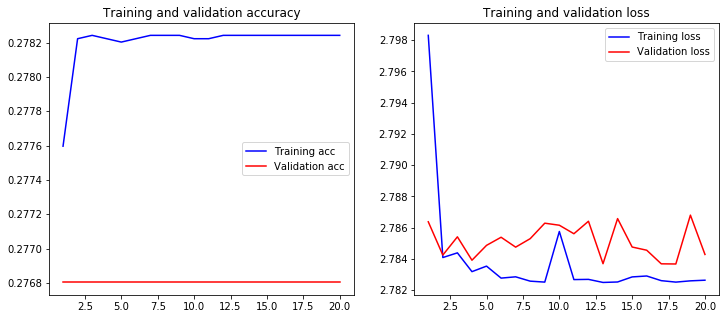

In [679]:
final_model_lstm = build_lstm_model(25, [50,50,25,25,25], 0.5)
history_final_model_lstm = final_model_lstm.fit(train_padded, train_labels, validation_data=(dev_padded, dev_labels), 
                                batch_size=batch_size, epochs=num_epochs)
plot_history(history_final_model_lstm)

In [798]:
scores = final_model_lstm.evaluate(test_padded, test_labels, verbose=0)
print('Test accuracy:', scores[1])

final_model_lstm_prediction = final_model_lstm.predict(test_padded)
print('F_1 Score:', f1_score([np.argmax(i) for i in final_model_lstm_prediction], test_labels, average ='macro'))

Test accuracy: 0.2823510766029358
F_1 Score: 0.0157273111314511


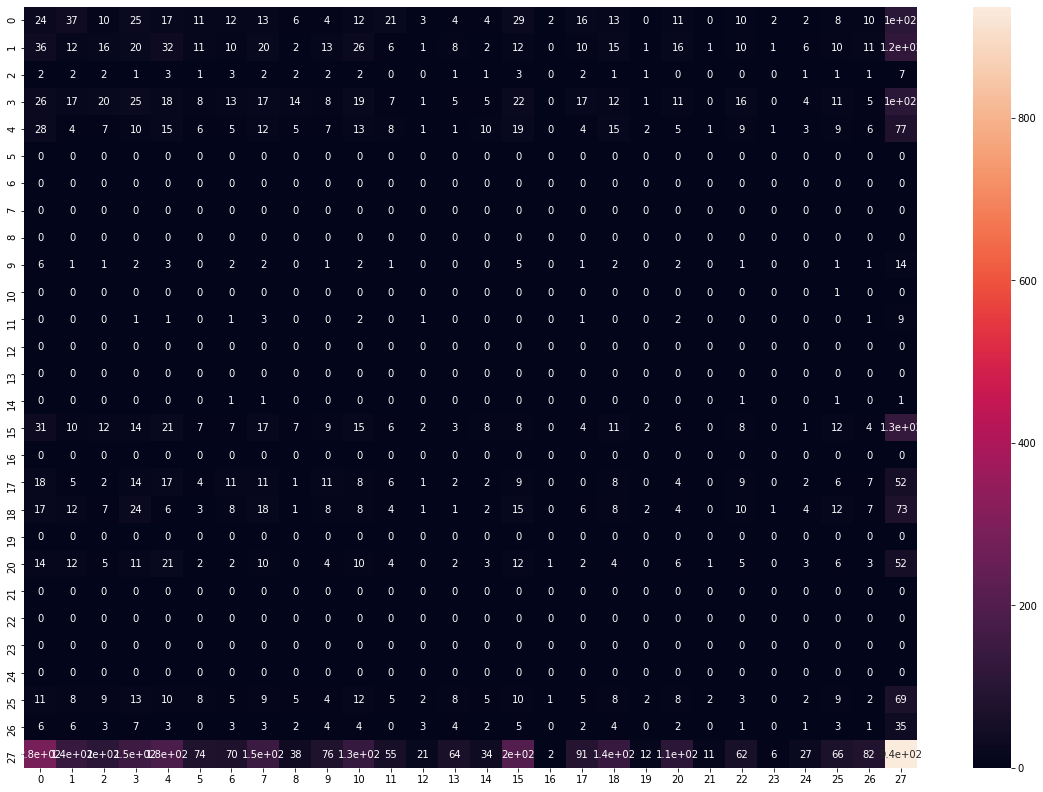

In [271]:
confusion_rnn = confusion_matrix(test_predict_labels, test_labels)
df_cm = pd.DataFrame(confusion_rnn, index = list(range(28)),
                  columns = list(range(28)))
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True)


Positive emotions get misclassified, negative emotions get misclassified. But we are in the ball park. Neutral throws things off. So what if we could separate all of them first and then feed them into separate networks?

In [278]:
# Maybe if we can start with a simplier classification, positive, negative, and neutral, 
# and then feed the positive and negative comments into another LSTM, that would be ideal. 

positive_emotions = [0,1,4,5,7,8,13,14,15,17,18,20,21,23,26] 
negative_emotions = [2,3,6,9,10,11,12,16,19,24,25,] #22 realization may or may not fit in here
neutral_emotions = [22, 27]

## Building Higher Level Classifier 

In [444]:
# General_emotion_id = 0 if positive, general_emotion_id = 1 if negative, and general_emotion_id = 2 if neutral

def higher_level_emotions(df):
    
    def check_emotions(emotion_id):
        if emotion_id in positive_emotions:
            general_emotion = 0
        elif emotion_id in negative_emotions:
            general_emotion = 1
        else:
            general_emotion = 2
        return general_emotion
    
    df['general_emotion_id'] = df['emotion_id'].map(check_emotions)
    return df

# DF with new high level emotion labels
higher_level_emotions(dev_processed)
higher_level_emotions(test_processed)
higher_level_emotions(train_processed)

dev_general_labels = dev_processed['general_emotion_id']
train_general_labels = train_processed['general_emotion_id']
test_general_labels = test_processed['general_emotion_id']



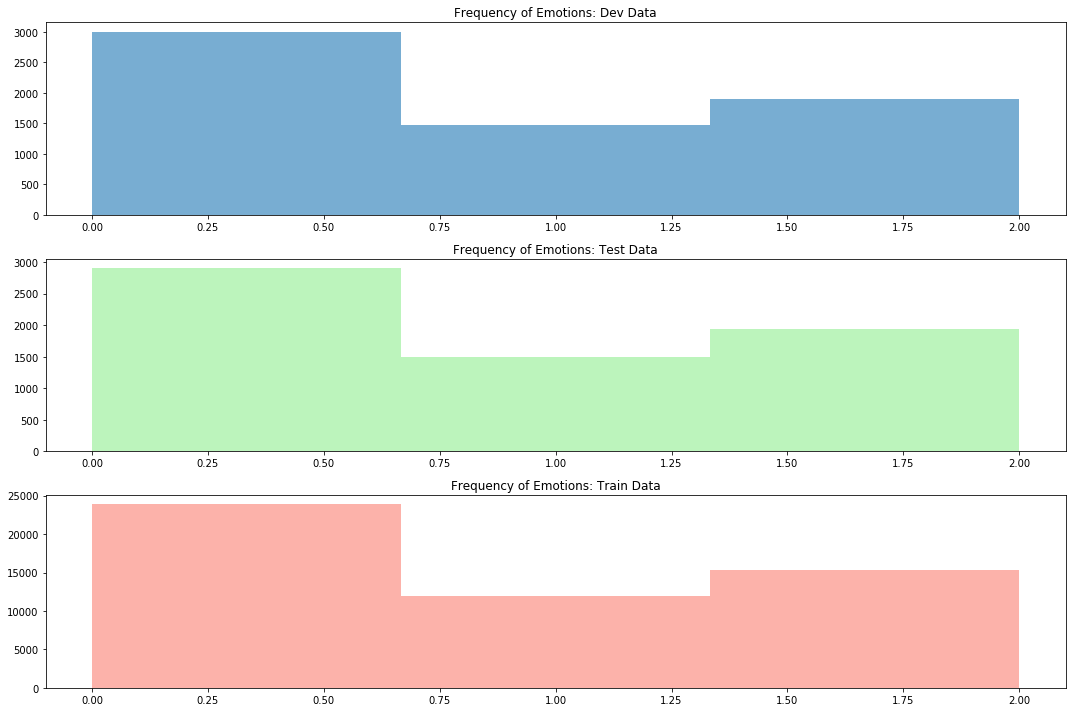

In [445]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].hist(dev_general_labels, bins=3, alpha=0.6)
axs[0].set_title("Frequency of Emotions: Dev Data")
axs[1].hist(test_general_labels, bins=3, color='lightgreen', alpha=0.6)
axs[1].set_title("Frequency of Emotions: Test Data")
axs[2].hist(train_general_labels, bins=3, color='salmon', alpha=0.6)
axs[2].set_title("Frequency of Emotions: Train Data")
fig.tight_layout()

In [446]:
#train_tokens and test_tokens from earlier RNN

max_words = 20
train_padded = sequence.pad_sequences(train_tokens, maxlen=max_words, padding='post')
test_padded = sequence.pad_sequences(test_tokens, maxlen=max_words, padding='post')

train_padded

array([[  17, 1138,  528, ...,    0,    0,    0],
       [  70,   34,   30, ...,   11,  124,  553],
       [  86,    2,  193, ...,    0,    0,    0],
       ...,
       [  32,   24,    5, ...,  197,    0,    0],
       [  67,   26,    4, ...,    0,    0,    0],
       [ 316,    2, 1571, ...,    0,    0,    0]], dtype=int32)

In [659]:
from keras.layers import Conv1D, Flatten, MaxPooling1D

def build_cnn_model(num_filters, kernel_size, pool_size, strides, hidden_dims, dropout):
    
    model = Sequential()
    
    #embedding layer
    model.add(Embedding((len(train_vocab) + 1), embedding_size, weights = [embedding_matrix], 
                    input_length=max_words, trainable=False))
    
    #convolutional layers
    model.add(Conv1D(num_filters, kernel_size = kernel_size, activation = 'relu', padding='same'))
    model.add(MaxPooling1D(pool_size = pool_size, strides = strides, padding = 'same'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    
    #hidden layers
    for n in hidden_dims:
        model.add(Dense(n, activation = 'relu'))
        model.add(Dropout(dropout))
    
    #output layer
    model.add(Dense(3, activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
             optimizer='adam', 
             metrics=['accuracy'])
    return model

cnn = build_cnn_model(30, 3, 2, 2, [50, 50, 50], 0.5)

In [666]:
batch_size = 20
num_epochs = 5

history = cnn.fit(train_padded, train_general_labels, validation_data=(dev_padded, dev_general_labels), 
        batch_size=batch_size, epochs=num_epochs)

Epoch 1/5
1023/1023 [==============================] - 5s 5ms/step - loss: 0.9168 - accuracy: 0.5518 - val_loss: 1.1249 - val_accuracy: 0.3679
Epoch 2/5
1023/1023 [==============================] - 6s 6ms/step - loss: 0.9122 - accuracy: 0.5519 - val_loss: 1.1363 - val_accuracy: 0.3534
Epoch 3/5
1023/1023 [==============================] - 4s 4ms/step - loss: 0.9064 - accuracy: 0.5562 - val_loss: 1.1368 - val_accuracy: 0.3558
Epoch 4/5
1023/1023 [==============================] - 5s 5ms/step - loss: 0.9026 - accuracy: 0.5571 - val_loss: 1.1306 - val_accuracy: 0.3392
Epoch 5/5
1023/1023 [==============================] - 4s 4ms/step - loss: 0.9008 - accuracy: 0.5702 - val_loss: 1.1517 - val_accuracy: 0.3254


In [661]:
scores = cnn.evaluate(test_padded, test_general_labels, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.37715280055999756


In [780]:
#grid search

num_filters = [20, 40]
kernel_size = [3]
pool_size = [2]
strides = [2]
hidden_dims = [[100,50,25,25], [100,100,50,50]]
dropout = [0.3]

batch_size = 20
num_epochs = 20

for n in num_filters:
    for k in kernel_size:
        for p in pool_size:
            for s in strides:
                for h in hidden_dims:
                    for d in dropout:
                        print("Model with", n, "filters,", k, "kernel_size,", p, "pool size,", s, "strides,", len(h), 
                              "hidden_dims,", d, "dropout")
                        model=build_cnn_model(n,k,p,s,h,d)
                        history = model.fit(train_padded, train_general_labels, 
                                            validation_data=(dev_padded, dev_general_labels), 
                                            batch_size=batch_size, epochs=num_epochs)
                        print("\n")
                        print(history.history['val_accuracy'][-1])
                        print("\n")
                        
                        
                        # 20 filters, 6 kernel_size, 2 pool size, 2 strides, [50, 50, 50, 50] hidden_dims, 0.6 dropout
                        # 20 filters, 6 kernel_size, 6 pool size, 4 strides, [50, 50, 50, 50] hidden_dims, 0.6 dropout

Model with 20 filters, 3 kernel_size, 2 pool size, 2 strides, 4 hidden_dims, 0.3 dropout
Epoch 1/20
2556/2556 [==============================] - 11s 4ms/step - loss: 1.0038 - accuracy: 0.4979 - val_loss: 1.1333 - val_accuracy: 0.3757
Epoch 2/20
2556/2556 [==============================] - 9s 4ms/step - loss: 0.9254 - accuracy: 0.5518 - val_loss: 1.1627 - val_accuracy: 0.3669
Epoch 3/20
2556/2556 [==============================] - 10s 4ms/step - loss: 0.8922 - accuracy: 0.5853 - val_loss: 1.1782 - val_accuracy: 0.3542
Epoch 4/20
2556/2556 [==============================] - 9s 4ms/step - loss: 0.8723 - accuracy: 0.5996 - val_loss: 1.1891 - val_accuracy: 0.3625
Epoch 5/20
2556/2556 [==============================] - 10s 4ms/step - loss: 0.8613 - accuracy: 0.6112 - val_loss: 1.2022 - val_accuracy: 0.3514
Epoch 6/20
2556/2556 [==============================] - 9s 4ms/step - loss: 0.8524 - accuracy: 0.6145 - val_loss: 1.1936 - val_accuracy: 0.3611
Epoch 7/20
2556/2556 [======================

2556/2556 [==============================] - 8s 3ms/step - loss: 0.7881 - accuracy: 0.6550 - val_loss: 1.3139 - val_accuracy: 0.3582
Epoch 16/20
2556/2556 [==============================] - 8s 3ms/step - loss: 0.7857 - accuracy: 0.6559 - val_loss: 1.2861 - val_accuracy: 0.3489
Epoch 17/20
2556/2556 [==============================] - 10s 4ms/step - loss: 0.7765 - accuracy: 0.6627 - val_loss: 1.2586 - val_accuracy: 0.3483
Epoch 18/20
2556/2556 [==============================] - 10s 4ms/step - loss: 0.7751 - accuracy: 0.6603 - val_loss: 1.2730 - val_accuracy: 0.3610
Epoch 19/20
2556/2556 [==============================] - 8s 3ms/step - loss: 0.7762 - accuracy: 0.6625 - val_loss: 1.3430 - val_accuracy: 0.3809
Epoch 20/20
2556/2556 [==============================] - 9s 3ms/step - loss: 0.7683 - accuracy: 0.6641 - val_loss: 1.2485 - val_accuracy: 0.3655


0.3655172288417816


Model with 40 filters, 3 kernel_size, 2 pool size, 2 strides, 4 hidden_dims, 0.3 dropout
Epoch 1/20
2556/2556 [======

Epoch 1/20
2556/2556 [==============================] - 13s 5ms/step - loss: 0.9919 - accuracy: 0.4941 - val_loss: 1.1284 - val_accuracy: 0.3538
Epoch 2/20
2556/2556 [==============================] - 10s 4ms/step - loss: 0.9162 - accuracy: 0.5618 - val_loss: 1.1536 - val_accuracy: 0.3317
Epoch 3/20
2556/2556 [==============================] - 11s 4ms/step - loss: 0.8898 - accuracy: 0.5894 - val_loss: 1.1739 - val_accuracy: 0.3588
Epoch 4/20
2556/2556 [==============================] - 10s 4ms/step - loss: 0.8710 - accuracy: 0.6053 - val_loss: 1.1629 - val_accuracy: 0.3466
Epoch 5/20
2556/2556 [==============================] - 9s 4ms/step - loss: 0.8599 - accuracy: 0.6133 - val_loss: 1.2545 - val_accuracy: 0.3734
Epoch 6/20
2556/2556 [==============================] - 9s 4ms/step - loss: 0.8480 - accuracy: 0.6208 - val_loss: 1.2138 - val_accuracy: 0.3475
Epoch 7/20
2556/2556 [==============================] - 11s 4ms/step - loss: 0.8430 - accuracy: 0.6255 - val_loss: 1.2537 - val_accu

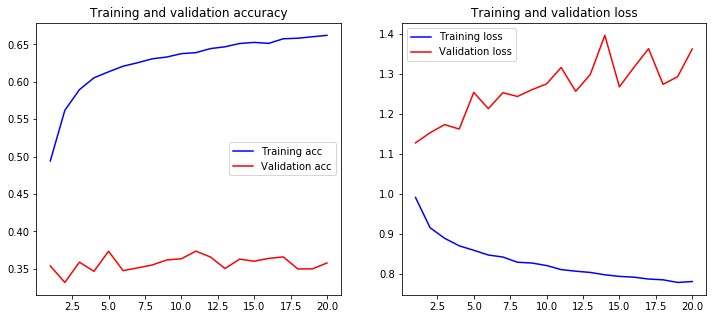

In [805]:
final_cnn_model = build_cnn_model(50,3,2,1,[50,30,30],0.4)
final_cnn_model_history = final_cnn_model.fit(train_padded, train_general_labels, validation_data=(dev_padded, dev_general_labels), 
        batch_size=batch_size, epochs=num_epochs)
plot_history(final_cnn_model_history)

In [803]:
#LSTM on 3 class classification
model_test = build_lstm_model(50, [50, 50, 50], 0.5)
history = model_test.fit(train_padded, train_general_labels, validation_data=(dev_padded, dev_general_labels), 
        batch_size=batch_size, epochs=num_epochs)

Epoch 1/20
2556/2556 [==============================] - 42s 16ms/step - loss: 1.0773 - accuracy: 0.4588 - val_loss: 1.0605 - val_accuracy: 0.4710
Epoch 2/20
2556/2556 [==============================] - 33s 13ms/step - loss: 1.0632 - accuracy: 0.4661 - val_loss: 1.0546 - val_accuracy: 0.4710
Epoch 3/20
2556/2556 [==============================] - 35s 14ms/step - loss: 1.0595 - accuracy: 0.4668 - val_loss: 1.0545 - val_accuracy: 0.4710
Epoch 4/20
2556/2556 [==============================] - 33s 13ms/step - loss: 1.0593 - accuracy: 0.4669 - val_loss: 1.0548 - val_accuracy: 0.4710
Epoch 5/20
2556/2556 [==============================] - 35s 14ms/step - loss: 1.0570 - accuracy: 0.4671 - val_loss: 1.0562 - val_accuracy: 0.4710
Epoch 6/20
2556/2556 [==============================] - 31s 12ms/step - loss: 1.0571 - accuracy: 0.4671 - val_loss: 1.0543 - val_accuracy: 0.4710
Epoch 7/20
2556/2556 [==============================] - 35s 14ms/step - loss: 1.0570 - accuracy: 0.4671 - val_loss: 1.0545 -

In [806]:
scores = model_test.evaluate(test_padded, test_general_labels, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.4593142569065094


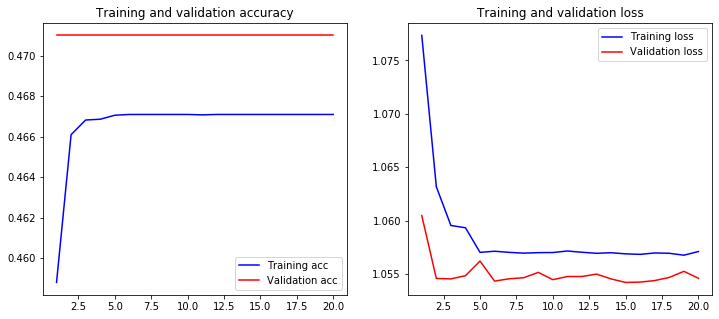

In [804]:
plot_history(history)

In [807]:
predicted = model.predict(test_padded)
f1_score([np.argmax(i) for i in predicted], test_general_labels, average = 'macro')



0.3341484545181122